### Scatter plot comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import pickle
import seaborn as sns
import xarray as xr
import cmocean
import geo_tools
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters

Tuning sets:
- sink06_sedice075_2015: sediment in ice = 0.75, resuspension_constant = 1.0, gamma = 0.065, sinking = 0.6
- sink06_sedice085_2015: sediment in ice = 0.85, resuspension_constant = 0.65, gamma = 0.065, sinking = 0.6
- sink06_resus04_2015  : sediment in ice = 0.85, resuspension_constant = 0.4, gamma = 0.065, sinking = 0.6

In [2]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

month   = 8

# results to load:
oldref_2015           = '/data/brogalla/run_storage/Mn-reference-202103/ref-2015-202103/ANHA12_EXH006_2015_monthly.nc'
sink06_sedice075_2015 = '/data/brogalla/run_storage/ANHA12_ref-2015_20210630/ANHA12_EXH006_2015_monthly.nc'
sink06_sedice085_2015 = '/data/brogalla/run_storage/ANHA12_ref-2015_20210708/ANHA12_EXH006_2015_monthly.nc'
sink06_resus04_2015   = '/data/brogalla/run_storage/ANHA12_ref-2015_20210710/ANHA12_EXH006_2015_monthly.nc'

# colours:
c_continent    = '#ce9169'
c_glacier      = '#36ab92'
c_other        = '#a6a6a6'
land_color     = "#8b7765"

file_list = [sink06_sedice075_2015, sink06_sedice085_2015, sink06_resus04_2015]

##### Load files

In [3]:
Mn_model     = nc.Dataset(oldref_2015)
lon_model    = np.array(Mn_model.variables['nav_lon'])
lat_model    = np.array(Mn_model.variables['nav_lat'])
depths_model = np.array(Mn_model.variables['deptht'])

In [4]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask    = np.array(mesh.variables['tmask'])[0,:,:,:]
mlons    = np.array(mesh.variables['nav_lon'])
mlats    = np.array(mesh.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask)

Observations

In [5]:
station_names = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
                'CB1', 'CB2', 'CB3', 'CB4']
station_stdev = ['Unnamed: 17', 'Unnamed: 20','Unnamed: 26', 'Unnamed: 29', 'Unnamed: 32', 'Unnamed: 35', \
                 'Unnamed: 38', 'Unnamed: 41','Unnamed: 44', 'Unnamed: 47', 'Unnamed: 50', 'Unnamed: 53']
station_depth = ['Depth.5','Depth.6','Depth.7','Depth.8','Depth.9','Depth.10','Depth.11','Depth.12','Depth.13', \
                'Depth.14','Depth.15','Depth.16','Depth.17']

In [6]:
observations = {'dissolmn': np.zeros((13,25)), 
                'stdev':np.zeros((13,25)), 
                'depth':np.zeros((13,25))} # dimensions: stations, depths
Mn_data      = pd.read_csv('/data/brogalla/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

for it, stn in enumerate(station_names):
    length = len(Mn_data[stn].dropna()[1:].astype('float'))
    observations['dissolmn'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_stdev):
    if stn=='Unnamed: 44':
        length = 11
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:11]
    elif stn=='Unnamed: 50':
        length = 22
        observations['stdev'][it][0:length] = Mn_data[stn][1:].astype('float').fillna(0)[0:22];
    else:
        length = len(Mn_data[stn].dropna()[1:].astype('float'))
        observations['stdev'][it][0:length] = Mn_data[stn].dropna()[1:].astype('float')
        
for it, stn in enumerate(station_depth):
    length = len(Mn_data[stn].dropna())
    observations['depth'][it][0:length]    = Mn_data[stn].dropna()

In [7]:
observations['dissolmn'][observations['dissolmn'] == 0] = np.nan

Mask bottom values of CAA2 and CAA7 (extreme spikes)

In [28]:
# #CAA2:
# observations['dissolmn'][1,11] = np.nan
# #CAA7:
# # observations['dissolmn'][6,6]  = np.nan
# observations['dissolmn'][6,7]  = np.nan

In [8]:
Pb_data   = pd.read_csv('/data/brogalla/Pb-paper-data.csv')
stn_names = Pb_data['Station names'][5:].dropna().astype('str')
lons      = Pb_data['station lon'][5:].astype('float').dropna().values
lats      = Pb_data['Station lat'][5:].astype('float').dropna().values

Get indices

In [9]:
stationi = np.empty((len(lons)))
stationj = np.empty((len(lons)))
for it, (lon, lat) in enumerate(zip(lons, lats)):
    i, j = geo_tools.find_closest_model_point(lon, lat, mesh_lon, mesh_lat, tols={
        'NEMO': {'tol_lon': 0.08, 'tol_lat': 0.015},
        })
    stationi[it] = i
    stationj[it] = j

In [10]:
stationi[2] = stationi[2]+1 # otherwise I think it's on land

In [11]:
# Match the depths of the observations with the model depths:
stationk = np.empty((13,25))
for stn in range(0,len(lons)):
    depths_obs = observations['depth'][stn,:]
    depths_obs[depths_obs==0] = np.nan
    for ind, depth in enumerate(depths_obs):
        k = np.argmin(np.abs(depths_model-depth))
        stationk[stn, ind] = k
        
stationk[stationk==0] = np.nan

Load model data

In [12]:
tuning_series = {'dissolmn': np.zeros((len(file_list),13,25))} # dimensions: tuning run, depth, stations
for it, filename in enumerate(file_list):
        data = xr.open_dataset(filename)
        for n, (i, j) in enumerate(zip(stationi, stationj)):
            for ind, k in enumerate(stationk[n,:]):
                try:
                    tuning_series['dissolmn'][it,n,ind] = data['dissolmn'][month,0,int(k),int(i-imin),int(j-jmin)]
                except:
                    tuning_series['dissolmn'][it,n,ind] = np.nan
        data.close()

In [13]:
tuning_series['dissolmn'][tuning_series['dissolmn'] == 0] = np.nan

### different parameter sets

Tuning sets:
- sink06_sedice075_2015: sediment in ice = 0.75, resuspension_constant = 1.0, gamma = 0.065, sinking = 0.6
- sink06_sedice085_2015: sediment in ice = 0.85, resuspension_constant = 0.65, gamma = 0.065, sinking = 0.6
- sink06_resus04_2015  : sediment in ice = 0.85, resuspension_constant = 0.4, gamma = 0.065, sinking = 0.6

Order of data: file_list = [sink06_sedice075_2015, sink06_sedice085_2015, sink06_resus04_2015]

In [14]:
c_tuning1 = '#ffe040'
c_tuning2 = '#7fa5f2'
c_tuning3 = '#9370db'
c_tuning4 = '#80d6ab'
c_tuning5 = '#9a004d'

In [15]:
# x-axis: year of spin-up
# y-axis: mean deviation from observations
# each runset has 1 color
resus_constant = (tuning_series['dissolmn'][2]-tuning_series['dissolmn'][1])/(0.40-0.65) # at 0.85 sedice
sedice_content = (tuning_series['dissolmn'][1]-tuning_series['dissolmn'][0])/(0.75-0.50) 

In [16]:
max_depth = np.nanmax(observations['depth'],axis=1)
depth_bdy = max_depth - 100 # for looking at the bottom, calculate the bottom depth

In [17]:
resus_rate = np.linspace(0,24,100) # sediment resuspension rate constant
sed_ice    = np.linspace(0,5.00,100) # sea ice sediment content
full_parameter_sets   = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'model_diff':np.zeros((100,100,80))}
bottom_parameter_sets = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'model_diff':np.zeros((100,100,80))}
upper_parameter_sets  = {'resus_rate': np.zeros((100,100,80)), 'sed_ice':np.zeros((100,100,80)), 'model_diff':np.zeros((100,100,80))}

mean_obs = np.nanmean(observations['dissolmn'].flatten())
upper_obs = np.nanmean(observations['dissolmn'][observations['depth'] < 100])

for it, r_param in enumerate(resus_rate):
    for jt, si_param in enumerate(sed_ice):
        full_parameter_sets['resus_rate'][it,jt]   = r_param
        full_parameter_sets['sed_ice'][it,jt]      = si_param
        bottom_parameter_sets['resus_rate'][it,jt] = r_param
        bottom_parameter_sets['sed_ice'][it,jt]    = si_param
        upper_parameter_sets['resus_rate'][it,jt]  = r_param
        upper_parameter_sets['sed_ice'][it,jt]     = si_param 
        
        # Full water column:
        mod      = tuning_series['dissolmn'][1] - (0.85*sedice_content + 0.65*resus_constant) \
                        + (resus_constant*r_param + sedice_content*si_param)
        mean_mod = np.nanmean(mod.flatten()*10**9)
        
        # Lower water column:
        bottom_obs = np.zeros(13); bottom_mod = np.zeros(13);
        for stn, depth_lim in enumerate(depth_bdy):     
            mod = tuning_series['dissolmn'][1,stn,:][observations['depth'][stn,:] > depth_lim] - \
                (0.85*sedice_content[stn,:][observations['depth'][stn,:] > depth_lim] + \
                 0.65*resus_constant[stn,:][observations['depth'][stn,:] > depth_lim]) \
                + resus_constant[stn,:][observations['depth'][stn,:] > depth_lim]*r_param + \
                sedice_content[stn,:][observations['depth'][stn,:] > depth_lim]*si_param
            bottom_obs[stn] = np.nanmean(observations['dissolmn'][stn,:][observations['depth'][stn,:] > depth_lim])
            bottom_mod[stn] = np.nanmean(mod.flatten()*10**9)

        # Upper water column:
        upper_mod = tuning_series['dissolmn'][1][observations['depth'] < 100] - \
                    (0.85*sedice_content[observations['depth'] < 100] + 0.65*resus_constant[observations['depth'] < 100]) \
                    + resus_constant[observations['depth'] < 100]*r_param + sedice_content[observations['depth'] < 100]*si_param 
        upper_mod = np.nanmean(upper_mod.flatten()*10**9)        
            
        # Write results:
        full_parameter_sets['model_diff'][it,jt]   = mean_mod - mean_obs
        upper_parameter_sets['model_diff'][it,jt]  = upper_mod - upper_obs
        bottom_parameter_sets['model_diff'][it,jt] = np.nanmean(bottom_mod) - np.nanmean(bottom_obs)

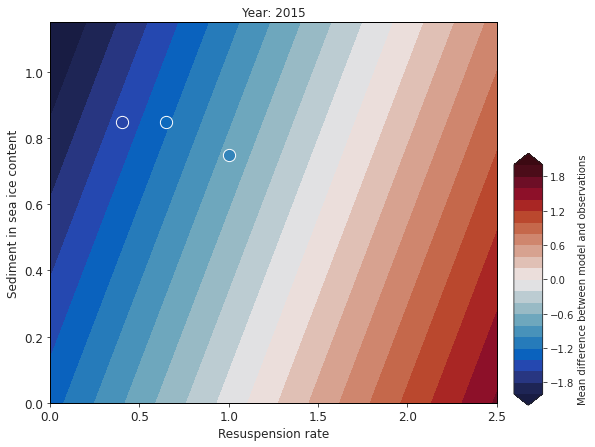

In [20]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -2
vup  = 2

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(full_parameter_sets['resus_rate'][:,:,7], \
                      full_parameter_sets['sed_ice'][:,:,7], \
                      full_parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')
    
    sns.scatterplot([1.0], [0.75], \
                    c=[np.nanmean(tuning_series['dissolmn'][0].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=150, zorder=3)
    sns.scatterplot([0.65], [0.85], \
                    c=[np.nanmean(tuning_series['dissolmn'][1].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=150, zorder=3)
    sns.scatterplot([0.4], [0.85], \
                    c=[np.nanmean(tuning_series['dissolmn'][2].flatten()*10**9) - \
                      np.nanmean(observations['dissolmn'].flatten())], \
                    cmap=cmocean.cm.balance, vmin=vlow, vmax=vup, s=150, zorder=3)

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 2.5), ylim=(0, 1.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/tuning-2021-07-12.png',bbox_inches='tight')

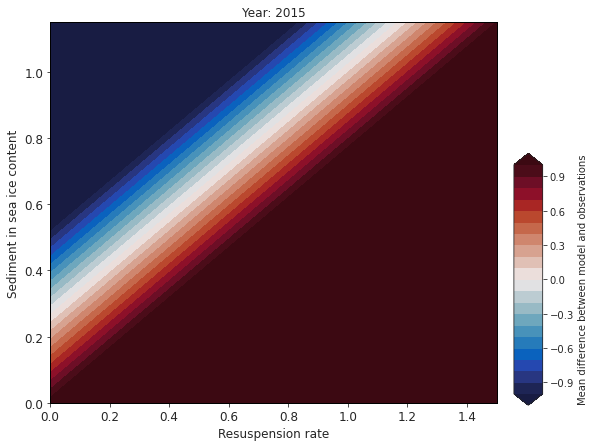

In [21]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1
vup  = 1

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(bottom_parameter_sets['resus_rate'][:,:,7], \
                      bottom_parameter_sets['sed_ice'][:,:,7], \
                      bottom_parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 1.5), ylim=(0, 1.15))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/tuning-bottom-2021-07-12.png',bbox_inches='tight')

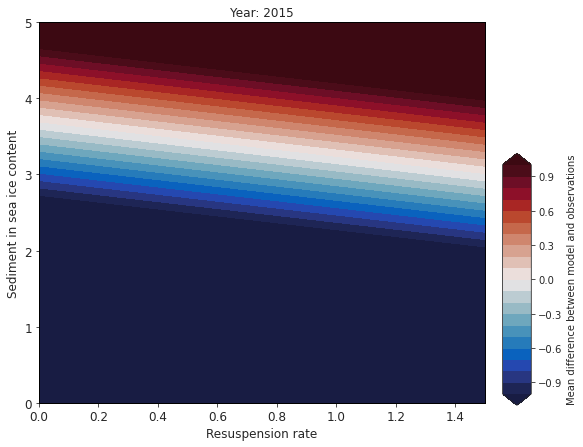

In [43]:
fig = plt.figure(figsize=(8,7))
st  = sns.axes_style("ticks")

vlow = -1
vup  = 1

with st:
    ax = sns.lineplot([-10,-9],[0,0])

    cm = plt.contourf(upper_parameter_sets['resus_rate'][:,:,7], \
                      upper_parameter_sets['sed_ice'][:,:,7], \
                      upper_parameter_sets['model_diff'][:,:,7], \
                      cmap=cmocean.cm.balance, levels=np.linspace(vlow,vup,21), vmin=vlow, vmax=vup, extend='both')

    ax.set_xlabel('Resuspension rate', fontsize=12)
    ax.set_ylabel('Sediment in sea ice content',fontsize=12)
    ax.set_title('Year: 2015', fontsize=12)
    ax.set(xlim=(0, 1.5), ylim=(0, 5))
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    cbaxes = fig.add_axes([0.93, 0.12, 0.05, 0.5])
    cbar   = plt.colorbar(cm, cax=cbaxes, label='Mean difference between model and observations')
    cbar.set_clim(-1.0,1.0)
    
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    